# Bolt Campaign Analyst Take Home Test

In [154]:
#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [155]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import datetime as dt
import seaborn as sns

# Data Sourcing

In [156]:
#Importing Datasets
demand_data_path="Demand Data.xlsx"
supply_data_path="Supply Data.xlsx"

In [157]:
#Conversion into Pandas Dataframe
df_demand=pd.read_excel(demand_data_path)
df_supply=pd.read_excel(supply_data_path)

In [158]:
##Inspecting the data (Un-Comment to run)
#df_demand.head()
#df_demand.tail()
#df_supply.head()
#df_supply.tail()

In [159]:
#Inspecting the dataframe
#print(df_supply.shape)
#print(df_supply.info())
#print(df_supply.describe())
#print("----------------------------")
#print(df_demand.shape)
#print(df_demand.info())
#print(df_demand.describe())

# Checking for data quality issues and cleaning

In [160]:
#Inspecting Null values and Empty Columns
df_demand.dropna(how='all', axis=1, inplace=True)
df_supply.dropna(how='all', axis=1, inplace=True)
df_supply.fillna(0)
df_demand.fillna(0)

,Date,People saw 0 cars (unique),People saw +1 cars (unique),Coverage Ratio (%)
0,2016-12-18 23,9,32,78
1,2016-12-18 22,29,64,69
2,2016-12-18 21,5,39,89
3,2016-12-18 20,13,48,79
4,2016-12-18 19,12,77,87
...,...,...,...,...
834,2016-11-14 04,4,4,50
835,2016-11-14 03,1,2,67
836,2016-11-14 02,3,6,67
837,2016-11-14 01,8,8,50


In [161]:
df_supply.head()

,Date,Active drivers,Online (h),Has booking (h),Waiting for booking (h),Hours per active driver,Rides per online hour,Finished Rides
0,2016-12-18 23,52,18,6,11,0.3,0.67,12.0
1,2016-12-18 22,59,20,11,9,0.3,1.40,28.0
2,2016-12-18 21,72,25,7,18,0.3,0.64,16.0
3,2016-12-18 20,86,29,7,23,0.3,0.52,15.0
4,2016-12-18 19,82,31,14,17,0.4,1.16,36.0


# Data preparation

In [162]:
# Merging the two dataframes according to the Date and Hour 
supply_demand=pd.merge(df_supply,df_demand)

In [163]:
supply_demand.head()

,Date,Active drivers,Online (h),Has booking (h),Waiting for booking (h),Hours per active driver,Rides per online hour,Finished Rides,People saw 0 cars (unique),People saw +1 cars (unique),Coverage Ratio (%)
0,2016-12-18 23,52,18,6,11,0.3,0.67,12.0,9,32,78
1,2016-12-18 22,59,20,11,9,0.3,1.40,28.0,29,64,69
2,2016-12-18 21,72,25,7,18,0.3,0.64,16.0,5,39,89
3,2016-12-18 20,86,29,7,23,0.3,0.52,15.0,13,48,79
4,2016-12-18 19,82,31,14,17,0.4,1.16,36.0,12,77,87


In [164]:
# Prepration of Approx demand 
supply_demand['Approx_Demand'] = supply_demand['People saw +1 cars (unique)']+supply_demand['People saw 0 cars (unique)']

Observation:

    Set A-> People saw +1 cars (unique)
    Set B-> People saw 0 cars (unique)
    
1) Since Set B contains some of the elements of Set A, their intersection is non-zero.

2) Union of these two sets will not give us the exact numbers for demand but a greater value which can be used approximate value
    

In [165]:
#Inorder to find an estimate of supply of drivers available, we need to check how many drivers are online.
supply_demand['Approx_Drivers_Supply']=(supply_demand['Active drivers'])-(supply_demand['Finished Rides']+(supply_demand['Has booking (h)']//supply_demand['Rides per online hour']))

Active Drivers will include Drivers already with a booking,drivers completing the ride, drivers waiting for a booking.
In order to find the approximate value of supply, we need to find the approximate number of free riders.

In [166]:
#Splitting the Date and Hours
supply_demand[['Date', 'Hour']] = supply_demand['Date'].str.split(' ', expand=True)

In [167]:
#Converting Date DateType into Datetime
supply_demand['Date'] = pd.to_datetime(supply_demand['Date'])
supply_demand['Date'] = supply_demand['Date'].dt.date

In [168]:
#Fetching Days from date for Insights
supply_demand['Date'] = pd.to_datetime(supply_demand['Date'], errors='coerce')
supply_demand['Day_Of_Week'] = supply_demand['Date'].dt.day_name()

In [169]:
#Breaking 24-hour time period into different timeslots for better analysis.
supply_demand['Hour'] = pd.to_numeric(supply_demand['Hour'], errors='coerce')
supply_demand.loc[supply_demand['Hour'].between(0,3, inclusive=True),'Timeslot'] = 'Late night'
supply_demand.loc[supply_demand['Hour'].between(4,6, inclusive=True),'Timeslot'] = 'Early morning'
supply_demand.loc[supply_demand['Hour'].between(7,12, inclusive=True),'Timeslot'] = 'Morning'
supply_demand.loc[supply_demand['Hour'].between(13,17, inclusive=True),'Timeslot'] = 'Afternoon'
supply_demand.loc[supply_demand['Hour'].between(18,20, inclusive=True),'Timeslot'] = 'Evening'
supply_demand.loc[supply_demand['Hour'].between(21,24, inclusive=True),'Timeslot'] = 'Night'

In [170]:
#supply_demand.tail()

# Data Analysis (Demand)

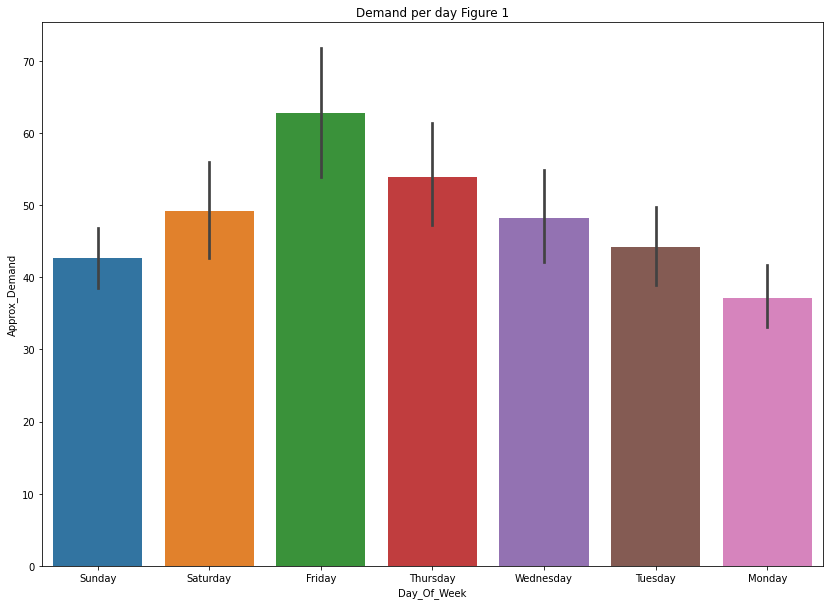

In [225]:
#looking to find the Demand count vs day sof week
plt.figure(num=None, figsize=(14, 10), facecolor='w', edgecolor='k')
ax =sns.barplot(x='Day_Of_Week',y='Approx_Demand', data=supply_demand)
plt.title("Demand per day Figure 1")
plt.show()
#Demand varies a lot with days, with the maximun demand on Friday followed by Thursday

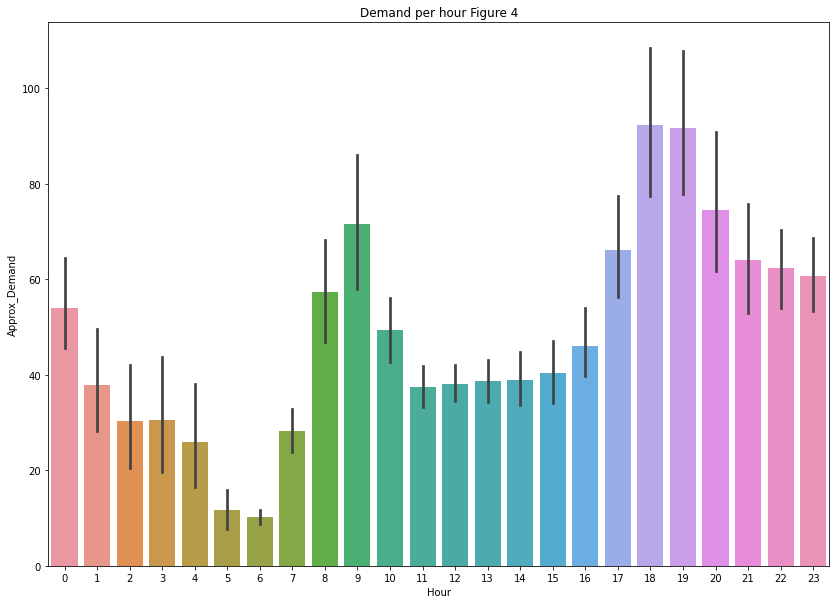

In [228]:
#looking to find the Demand count VS Hours
plt.figure(num=None, figsize=(14, 10), facecolor='w', edgecolor='k')
sns.barplot(x='Hour',y='Approx_Demand', data=supply_demand)
plt.title("Demand per hour Figure 4")
plt.show()
#Early morning hours (0800-0900) and Evening hours (1800-1900) are found to have maximun demand.
#This can be broadly broken into Timeslots shown below

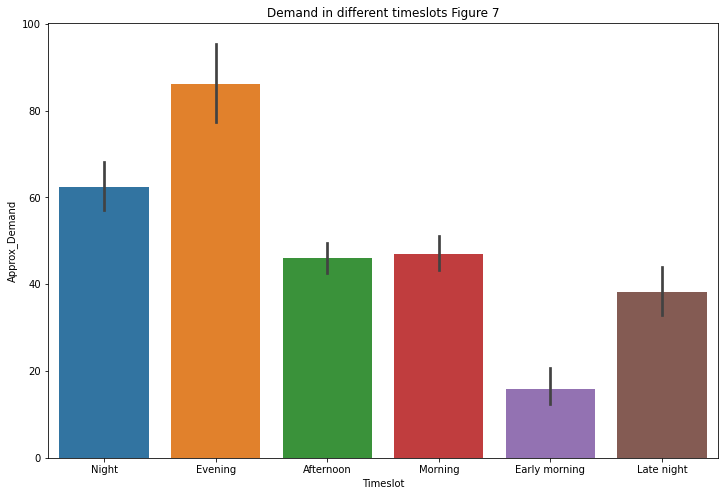

In [232]:
#looking to find the Demand count VS Timeslots
plt.figure(num=None, figsize=(12, 8), facecolor='w', edgecolor='b')
ax =sns.barplot(x='Timeslot',y='Approx_Demand', data=supply_demand)

plt.title("Demand in different timeslots Figure 7")
plt.show()

# Data Analysis (Supply)

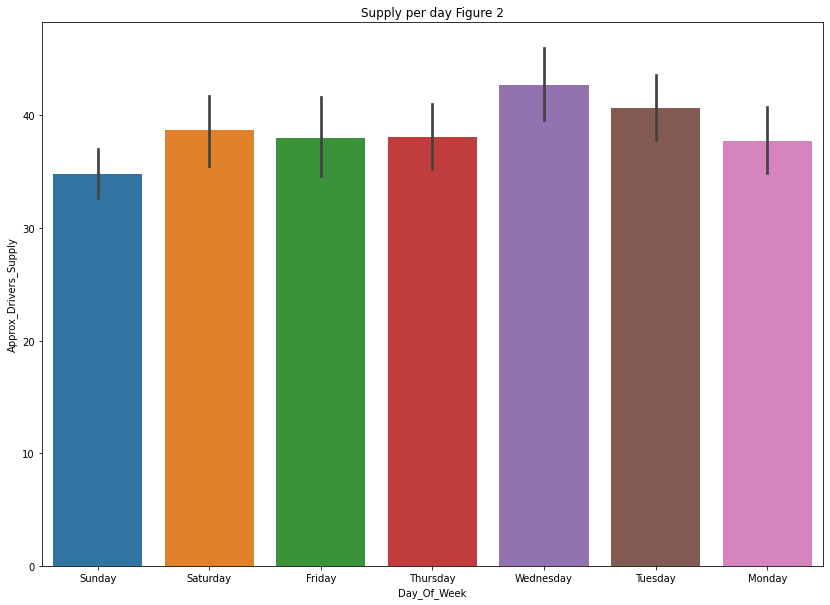

In [233]:
#looking to find the Supply count vs day sof week
plt.figure(num=None, figsize=(14, 10), facecolor='w', edgecolor='k')
ax =sns.barplot(x='Day_Of_Week',y='Approx_Drivers_Supply', data=supply_demand)
plt.title("Supply per day Figure 2")
plt.show()
#Supply doesn't varies a lot with days, with the maximun supply on Wednesday.

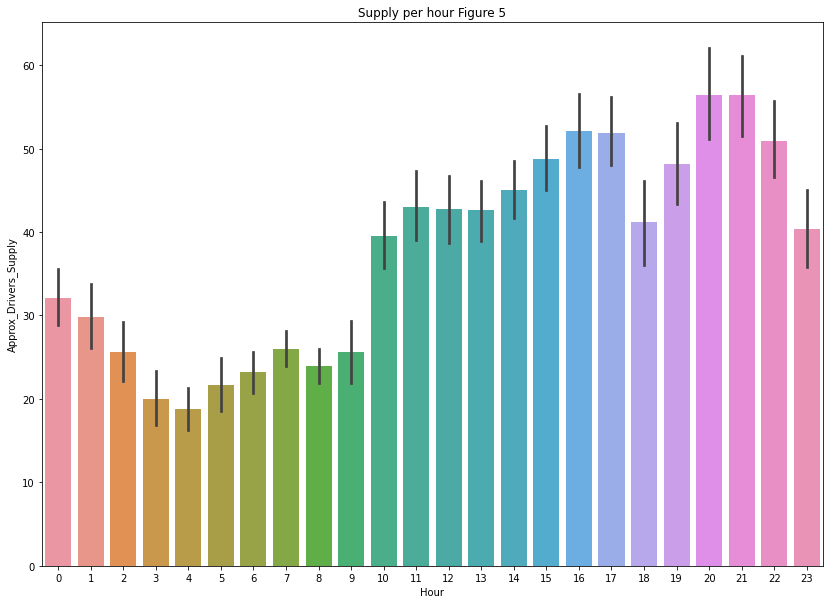

In [234]:
#looking to find the Supply count VS Hours
plt.figure(num=None, figsize=(14, 10), facecolor='w', edgecolor='k')
sns.barplot(x='Hour',y='Approx_Drivers_Supply', data=supply_demand)
plt.title("Supply per hour Figure 5")
plt.show()
# Early Mornings and Late Night hours (0200-0300) have the least supply 
#and Evening hours (1900-2200) are found to have maximun supply.
#This can be broadly broken into Timeslots shown below

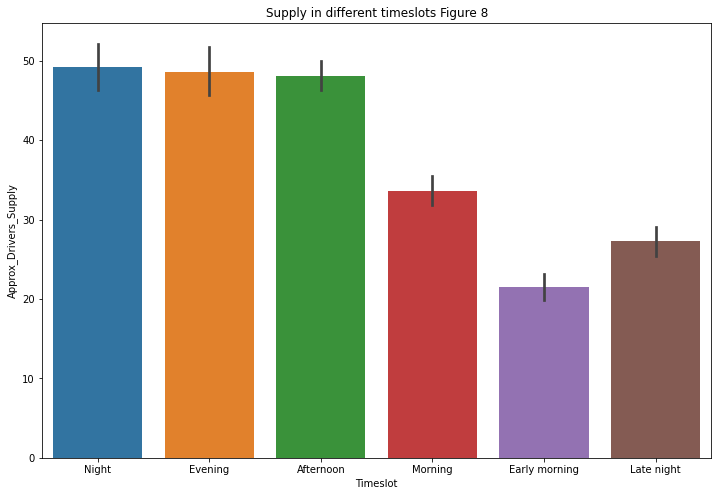

In [235]:
#looking to find the Supply count VS Timeslots
plt.figure(num=None, figsize=(12, 8), facecolor='w', edgecolor='b')
ax =sns.barplot(x='Timeslot',y='Approx_Drivers_Supply', data=supply_demand)

plt.title("Supply in different timeslots Figure 8")
plt.show()

# Demand-Supply Gap Estimation

In [236]:
#Generation of a new Dataframe for easy redability
Gap = supply_demand[['Date', 'Hour', 'Day_Of_Week','Timeslot','Approx_Demand','Approx_Drivers_Supply','Hours per active driver','Rides per online hour']].copy()
Gap.replace(np.nan, 0)

,Date,Hour,Day_Of_Week,Timeslot,Approx_Demand,Approx_Drivers_Supply,Hours per active driver,Rides per online hour
0,2016-12-18,23,Sunday,Night,41,32.0,0.3,0.67
1,2016-12-18,22,Sunday,Night,93,24.0,0.3,1.40
2,2016-12-18,21,Sunday,Night,44,46.0,0.3,0.64
3,2016-12-18,20,Sunday,Evening,61,58.0,0.3,0.52
4,2016-12-18,19,Sunday,Evening,89,34.0,0.4,1.16
...,...,...,...,...,...,...,...,...
834,2016-11-14,4,Monday,Early morning,8,0.0,0.4,0.00
835,2016-11-14,3,Monday,Late night,3,0.0,0.4,0.00
836,2016-11-14,2,Monday,Late night,9,20.0,0.3,0.14
837,2016-11-14,1,Monday,Late night,16,23.0,0.3,0.22


In [208]:
#Plot Function for Visualizing
def plot_function(x,y1,y2,title):
    plt.figure(figsize=(14, 12))
    plt.plot(x,y1,'o-',label="Estimated Supply")
    plt.plot(x,y2,'o-',label="Estimated Demand")
    plt.legend()
    plt.grid()
    plt.title(title)
    
    plt.show()

In [209]:
#Grouping by Hours to calculate the mean value of Approximate Demand and Approximate Supply
Gap_by_hour=Gap.groupby('Hour').mean()

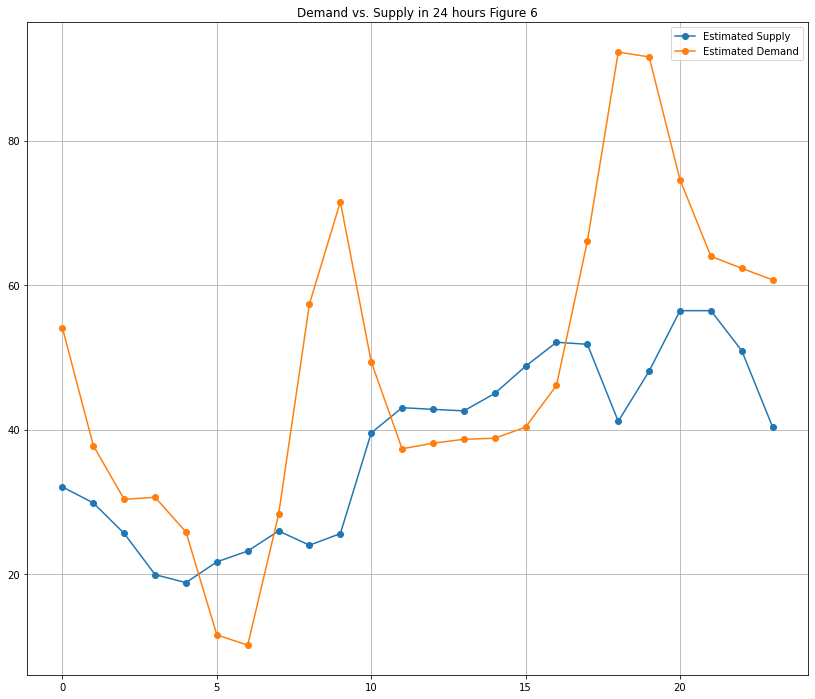

In [230]:
x=[]
for i in range(24):
    x.append(i)
y1=Gap_by_hour['Approx_Drivers_Supply']
y2=Gap_by_hour['Approx_Demand']
title='Demand vs. Supply in 24 hours Figure 6'
plot_function(x,y1,y2,title)

In [211]:
#Grouping by Days to calculate the mean value of Approximate Demand and Approximate Supply
Gap_by_days=Gap.groupby('Day_Of_Week').mean().round()

In [212]:
#Gap_by_days

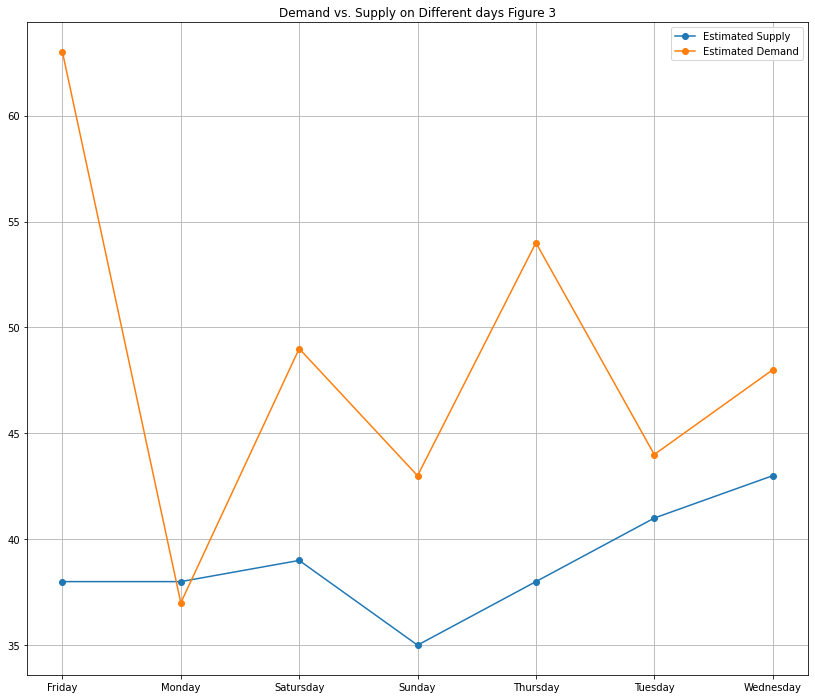

In [227]:
x=['Friday','Monday','Satursday','Sunday','Thursday','Tuesday','Wednesday']

y1=Gap_by_days['Approx_Drivers_Supply']
y2=Gap_by_days['Approx_Demand']
title='Demand vs. Supply on Different days Figure 3'

plot_function(x,y1,y2,title)

In [214]:
#Grouping by Timeslots to calculate the mean value of Approximate Demand and Approximate Supply
Gap_by_Timeslot=Gap.groupby('Timeslot').mean().round()

In [215]:
#Gap_by_Timeslot

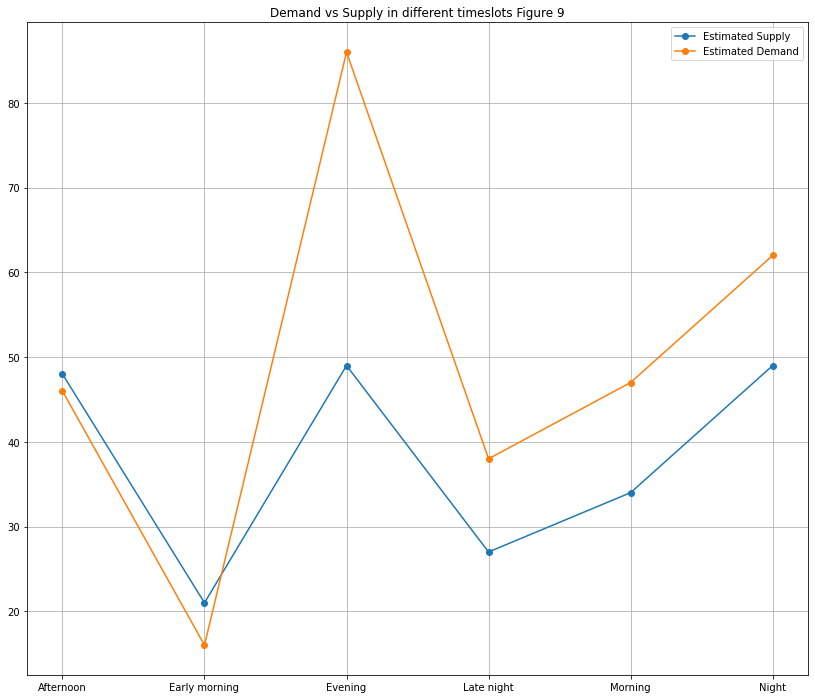

In [231]:
x=['Afternoon','Early morning','Evening','Late night','Morning','Night']
y1=Gap_by_Timeslot['Approx_Drivers_Supply']
y2=Gap_by_Timeslot['Approx_Demand']
title="Demand vs Supply in different timeslots Figure 9"

plot_function(x,y1,y2,title)

# Required Online Hour Calculation

In [217]:
hour=[]
for i in range(24):
    hour.append(i)
Gap_by_hour['Hour_value']=hour

In [218]:
#Inorder to calculate the online hours needed, 
#we need to find the difference between Demand and Supply. This will give us the number of riders needed. 

In [219]:
Gap_by_hour['Gap']=Gap_by_hour['Approx_Demand']-Gap_by_hour['Approx_Drivers_Supply']
Gap_by_hour['Needed_Hours']=Gap_by_hour['Gap']*Gap_by_hour['Hours per active driver']


In [220]:
Gap_by_hour

,Approx_Demand,Approx_Drivers_Supply,Hours per active driver,Rides per online hour,Hour_value,Gap,Needed_Hours
Hour,,,,,,,
0,54.057143,32.057143,0.402857,0.764286,0,22.000000,8.862857
1,37.771429,29.852941,0.388571,0.550571,1,7.918487,3.076898
2,30.342857,25.625000,0.388571,0.518857,2,4.717857,1.833224
3,30.628571,19.928571,0.388571,0.492857,3,10.700000,4.157714
4,25.828571,18.818182,0.368571,0.468000,4,7.010390,2.583829
5,11.588235,21.695652,0.367647,0.273235,5,-10.107417,-3.715962
6,10.171429,23.193548,0.308571,0.219143,6,-13.022120,-4.018254
7,28.257143,25.969697,0.322857,0.588000,7,2.287446,0.738518
8,57.400000,24.000000,0.354286,0.819429,8,33.400000,11.833143


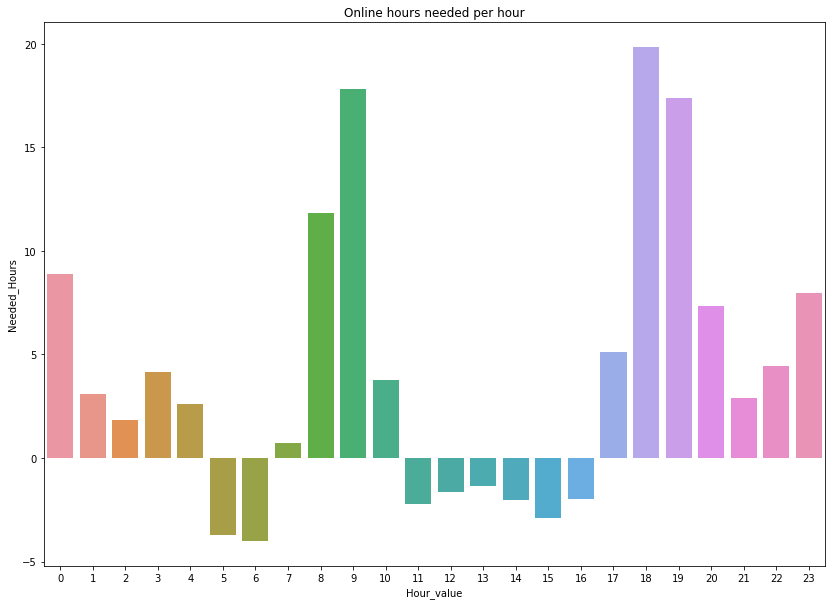

In [223]:
#looking to Hours needed per hours
plt.figure(num=None, figsize=(14, 10), facecolor='w', edgecolor='k')
sns.barplot(x='Hour_value',y='Needed_Hours', data=Gap_by_hour)
plt.title("Online hours needed per hour")
plt.show()

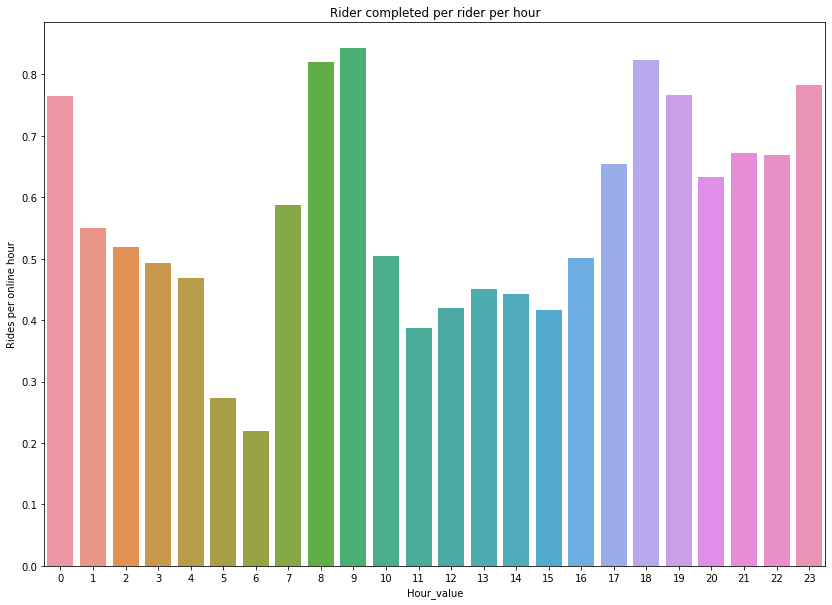

In [224]:
#looking to find the Avg Ride per hour VS Hours
plt.figure(num=None, figsize=(14, 10), facecolor='w', edgecolor='k')
sns.barplot(x='Hour_value',y='Rides per online hour', data=Gap_by_hour)
plt.title("Rider completed per rider per hour")
plt.show()